# Import

In [1]:
# math and dataframes
import pandas as pd
import numpy as np

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

# Pipeline and Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.tree import plot_tree
from imblearn.pipeline import make_pipeline

# Undersampling 
# Note: undersampling was used in at least 1 paper predicting popularity (Gao 2021)
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import seaborn as sns
sns.set_theme()

In [2]:
df_10M = pd.read_pickle('df_10M_clustered.pickle')
X_all = pd.read_pickle('X_clustered.pickle')

# Create Datasets for Prediction

In [3]:
y_column = 'in_B100'
X_columns = [
    'mode', 'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]
genre_columns = [
    'is_Adult_Standard', 'is_Rock', 'is_R&B', 'is_Country', 'is_Pop',
    'is_Rap', 'is_Alternative', 'is_EDM', 'is_Metal'
]
cluster_columns = ['cluster', 'cluster2']
other_columns = ['key', 'time_signature', 'genre', 'release_date']


In [4]:
# create a dict with all 'name': (X, y) key match pairs
clusters = {}

# entire predictive dataset
clusters['All'] = (X_all[X_columns], X_all[y_column])

# add genres
for genre in genre_columns:
    title = genre[3:]
    clusters[title] = (X_all[X_all[genre]][X_columns], X_all[X_all[genre]][y_column])
    
# add clusters
for n in sorted(X_all['cluster'].unique()):
    title = genre[3:]
    clusters['cluster1_' + str(n)] = (X_all[X_all['cluster'] == n][X_columns], X_all[X_all['cluster'] == n][y_column])
    
for n in sorted(X_all['cluster2'].unique()):
    title = genre[3:]
    clusters['cluster2_' + str(n)] = (X_all[X_all['cluster2'] == n][X_columns], X_all[X_all['cluster2'] == n][y_column])
    
# OPTIONAL IF TIME PERMITS: consider adding decades or eras of music

In [5]:
# main non-clustered predictive dataset (all data)
X, y = clusters['All']

In [8]:
clusters.keys()

dict_keys(['All', 'Adult_Standard', 'Rock', 'R&B', 'Country', 'Pop', 'Rap', 'Alternative', 'EDM', 'Metal', 'cluster1_0', 'cluster1_1', 'cluster1_2', 'cluster1_3', 'cluster2_0', 'cluster2_1', 'cluster2_2', 'cluster2_3', 'cluster2_4', 'cluster2_5', 'cluster2_6', 'cluster2_7', 'cluster2_8', 'cluster2_9'])

# Compare Algorithms
### Check Calculation Speeds

In [7]:
ML_algorithms = [
    LogisticRegression,
    DecisionTreeClassifier,
#     SVC,  # WAY too slow, would take days/months
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
]

In [8]:
# these are slow, even the simlest models
# let's see how long they take with a small and medium dataset
# then we can estimate how long each algorithm will take to run

small = X_all.sample(10_000)
y_small = small[y_column]
X_small = small[X_columns]

medium = X_all.sample(100_000)
y_medium = medium[y_column]
X_medium = medium[X_columns]

large = X_all.sample(1_000_000)
y_large = large[y_column]
X_large = large[X_columns]

In [9]:
def ml_time(X, y, ml_n):
    """testing how long each algorithm takes"""
    grid = GridSearchCV(
        estimator=ML_algorithms[ml_n](),
        param_grid={},
        cv=5
    )
    %time grid.fit(X, y)

In [10]:
# small datasets
for i in range(len(ML_algorithms)):
    print(str(ML_algorithms[i])[:-2].split('.')[-1], end=': ')
    ml_time(X_small, y_small, i)

LogisticRegression: Wall time: 131 ms
DecisionTreeClassifier: Wall time: 228 ms
RandomForestClassifier: Wall time: 3.69 s
AdaBoostClassifier: Wall time: 2.33 s
GradientBoostingClassifier: Wall time: 9.35 s


In [11]:
# medium datasets
for i in range(len(ML_algorithms)):
    print(str(ML_algorithms[i])[:-2].split('.')[-1], end=': ')
    ml_time(X_medium, y_medium, i)

LogisticRegression: Wall time: 981 ms
DecisionTreeClassifier: Wall time: 3.74 s
RandomForestClassifier: Wall time: 1min 2s
AdaBoostClassifier: Wall time: 21.4 s
GradientBoostingClassifier: Wall time: 1min 38s


In [12]:
# medium datasets
for i in range(len(ML_algorithms)):
    print(str(ML_algorithms[i])[:-2].split('.')[-1], end=': ')
    ml_time(X_large, y_large, i)

LogisticRegression: Wall time: 11.8 s
DecisionTreeClassifier: Wall time: 1min 3s
RandomForestClassifier: Wall time: 25min 24s
AdaBoostClassifier: Wall time: 6min 8s
GradientBoostingClassifier: Wall time: 21min 36s


Time Complexity Notes:
* Naive Bayes: O(n*d)
* Logistic Regression: O(n*d)
* Decision Tree: O(n*log(n))
* SVC: O(n^2)
    * Note from medium.com: "if n is large, avoid using SVM."
* Random Forest: O(n*log(n)*k)
    * i assume other boosted trees are similar
    
    
REFERENCE:
https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770

* based on the above times, it will take about this long to calculate without resampling:
    * LogisticRegression: 1 minute
    * DecisionTreeClassifier: Wall time: 15 minutes
    * RandomForestClassifier: Wall time: 7 hours
    * AdaBoostClassifier: Wall time: 58 minutes
    * GradientBoostingClassifier: Wall time: 4 hours
    
Note: could take less time if undersampled

### let's try logistic regression and decision tree to see if we're right

In [18]:
%%time
# test logistic regression

grid = GridSearchCV(
    estimator=ML_algorithms[0](),
    param_grid={},
    cv=5
)
grid.fit(X, y)

grid.cv_results_

Wall time: 2min 4s


{'mean_fit_time': array([18.24480934]),
 'std_fit_time': array([2.34020124]),
 'mean_score_time': array([0.8958056]),
 'std_score_time': array([0.00415563]),
 'params': [{}],
 'split0_test_score': array([0.99759508]),
 'split1_test_score': array([0.99759508]),
 'split2_test_score': array([0.99759508]),
 'split3_test_score': array([0.99759508]),
 'split4_test_score': array([0.99759564]),
 'mean_test_score': array([0.99759519]),
 'std_test_score': array([2.26014337e-07]),
 'rank_test_score': array([1])}

In [19]:
# almost 100% accurate by predicting no songs are hits
# need to deal with unbalanced data, but for now, it looks like it's working
1 - sum(y) / y.shape[0]

0.997595188519254

In [20]:
%%time
# check decision tree, different method, just the score
cross_val_score(ML_algorithms[1](), X, y, cv=5, scoring='accuracy').mean()

Wall time: 13min 25s


0.9943485966896315

# Improve Speed and Results
### UNDERSAMPLING

https://imbalanced-learn.org/stable/under_sampling.html

### Also STRATIFIED CROSSVALIDATION 
https://scikit-learn.org/stable/modules/cross_validation.html

MSE: 1.00   stdev Error: 0.00



C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00   8806490
        True       0.00      0.00      0.00     21229

    accuracy                           1.00   8827719
   macro avg       0.50      0.50      0.50   8827719
weighted avg       1.00      1.00      1.00   8827719



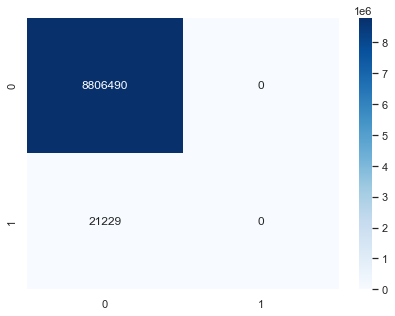

Wall time: 3min 9s


In [45]:
%%time
# default method

# stratified sampling
cv = StratifiedKFold(n_splits=5, shuffle=True)
lr_model = LogisticRegression()
scores = cross_val_score(lr_model, X, y, cv=cv, n_jobs=-1)

# print results
print(f'MSE: {np.mean(scores):.2f}   stdev Error: {np.std(scores):.2f}\n')

y_pred = cross_val_predict(lr_model, X, y, cv=cv)
print(classification_report(y, y_pred))

plt.subplots(figsize=(7, 5))
sns.heatmap(confusion_matrix(y, y_pred), cmap='Blues', annot=True, fmt='.0f')
plt.show()

MSE: 0.69   stdev Error: 0.01

              precision    recall  f1-score   support

       False       0.74      0.58      0.65     21229
        True       0.65      0.80      0.72     21229

    accuracy                           0.69     42458
   macro avg       0.70      0.69      0.69     42458
weighted avg       0.70      0.69      0.69     42458



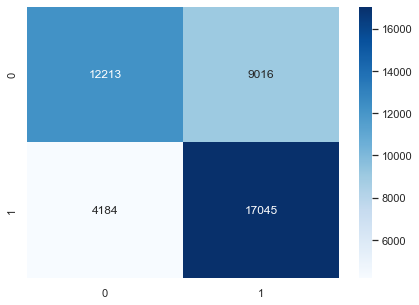

Wall time: 2.75 s


In [44]:
%%time
# undersample method
undersample = RandomUnderSampler()
Xu, yu = undersample.fit_resample(X, y)

# stratified sampling
cv = StratifiedKFold(n_splits=5, shuffle=True)
lr_model = LogisticRegression()

# calculate and print results
scores = cross_val_score(lr_model, Xu, yu, cv=cv, n_jobs=-1)
print(f'MSE: {np.mean(scores):.2f}   stdev Error: {np.std(scores):.2f}\n')

y_pred = cross_val_predict(lr_model, Xu, yu, cv=cv)
print(classification_report(yu, y_pred))

plt.subplots(figsize=(7, 5))
sns.heatmap(confusion_matrix(yu, y_pred), cmap='Blues', annot=True, fmt='.0f')
plt.show()

MSE: 0.57   stdev Error: 0.00

              precision    recall  f1-score   support

       False       1.00      0.57      0.72   8806490
        True       0.00      0.80      0.01     21229

    accuracy                           0.57   8827719
   macro avg       0.50      0.69      0.37   8827719
weighted avg       1.00      0.57      0.72   8827719



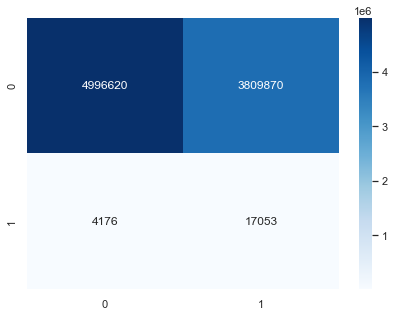

Wall time: 2min 44s


In [46]:
%%time
# balanced class weights

# stratified sampling
cv = StratifiedKFold(n_splits=5, shuffle=True)
lr_model = LogisticRegression(class_weight='balanced')

# calculate and print results
scores = cross_val_score(lr_model, X, y, cv=cv, n_jobs=-1)
print(f'MSE: {np.mean(scores):.2f}   stdev Error: {np.std(scores):.2f}\n')

y_pred = cross_val_predict(lr_model, X, y, cv=cv)
print(classification_report(y, y_pred))

plt.subplots(figsize=(7, 5))
sns.heatmap(confusion_matrix(y, y_pred), cmap='Blues', annot=True, fmt='.0f')
plt.show()

MSE: 0.69   stdev Error: 0.00

              precision    recall  f1-score   support

       False       0.74      0.57      0.64   8806490
        True       0.65      0.80      0.72   8806490

    accuracy                           0.69  17612980
   macro avg       0.70      0.69      0.68  17612980
weighted avg       0.70      0.69      0.68  17612980



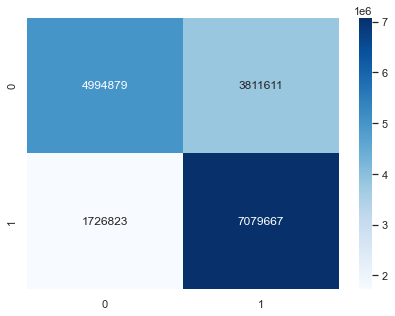

Wall time: 4min 39s


In [47]:
%%time
# oversample method
oversample = RandomOverSampler()
Xo, yo = oversample.fit_resample(X, y)

# stratified sampling
cv = StratifiedKFold(n_splits=5, shuffle=True)
lr_model = LogisticRegression()

# calculate and print results
scores = cross_val_score(lr_model, Xo, yo, cv=cv, n_jobs=-1)
print(f'MSE: {np.mean(scores):.2f}   stdev Error: {np.std(scores):.2f}\n')

y_pred = cross_val_predict(lr_model, Xo, yo, cv=cv)
print(classification_report(yo, y_pred))

plt.subplots(figsize=(7, 5))
sns.heatmap(confusion_matrix(yo, y_pred), cmap='Blues', annot=True, fmt='.0f')
plt.show()


#### looks like undersampling is almost as good as oversampling, and WAY faster
<br>
<div>
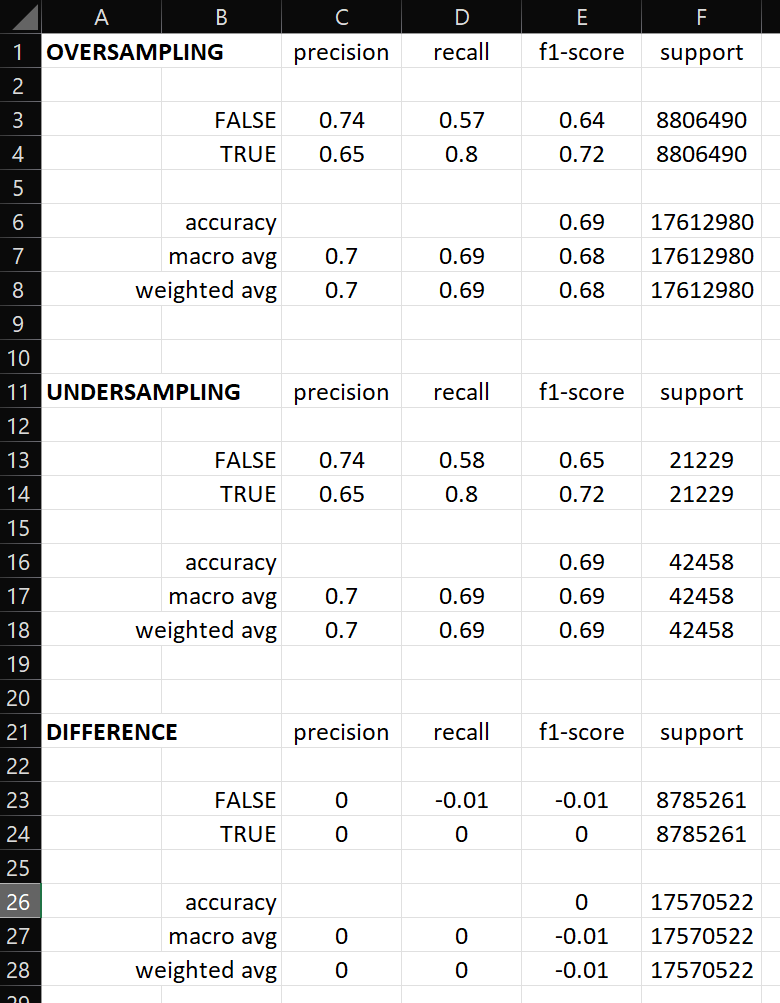
</div>

# Compare Algorithms
### Make Predictions Using Default ML Settings

In [6]:
cluster_keys = [
    'All', 
    'Adult_Standard', 'Rock', 'R&B', 'Country', 'Pop', 'Rap', 'Alternative', 'EDM', 'Metal', 
    'cluster1_0', 'cluster1_1', 'cluster1_2', 'cluster1_3', 
    'cluster2_0', 'cluster2_1', 'cluster2_2', 'cluster2_3', 'cluster2_4', 
    'cluster2_5', 'cluster2_6', 'cluster2_7', 'cluster2_8', 'cluster2_9'
]

ML_algorithms = [
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    AdaBoostClassifier
]

------------------------------------------------------------------------------------
LogisticRegression cluster2_6

              precision    recall  f1-score   support

       False       1.00      0.61      0.75    316993
        True       0.00      0.67      0.01       883

    accuracy                           0.61    317876
   macro avg       0.50      0.64      0.38    317876
weighted avg       1.00      0.61      0.75    317876



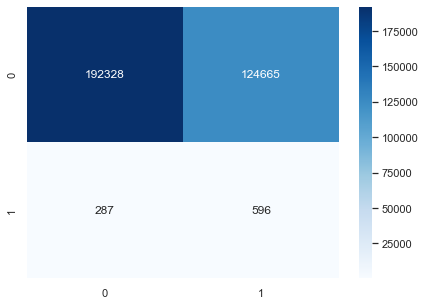

------------------------------------------------------------------------------------
DecisionTreeClassifier cluster2_6

              precision    recall  f1-score   support

       False       1.00      0.58      0.73    316993
        True       0.00      0.62      0.01       883

    accuracy                           0.58    317876
   macro avg       0.50      0.60      0.37    317876
weighted avg       1.00      0.58      0.73    317876



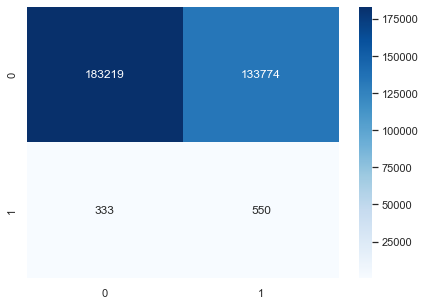

------------------------------------------------------------------------------------
RandomForestClassifier cluster2_6

              precision    recall  f1-score   support

       False       1.00      0.68      0.81    316993
        True       0.01      0.63      0.01       883

    accuracy                           0.68    317876
   macro avg       0.50      0.66      0.41    317876
weighted avg       1.00      0.68      0.81    317876



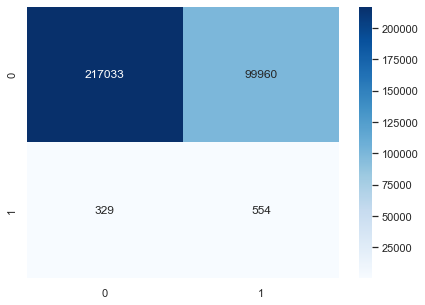

------------------------------------------------------------------------------------
AdaBoostClassifier cluster2_6

              precision    recall  f1-score   support

       False       1.00      0.59      0.74    316993
        True       0.00      0.68      0.01       883

    accuracy                           0.59    317876
   macro avg       0.50      0.63      0.37    317876
weighted avg       1.00      0.59      0.74    317876



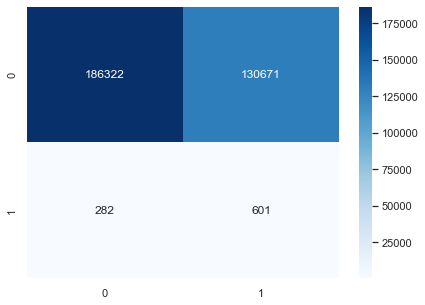

Wall time: 12.5 s


In [75]:
%%time
# save results
default_results = {}

# choose dataset and algorithm
n_cluster = 0
n_algorithm = 0

# loop through algorithms
for algorithm in ML_algorithms:
    
    model_name = str(algorithm())[:-2]
    default_results[model_name] = {}

    # loop through clusters
    for cluster_key in cluster_keys:
        
        # create working dataset
        # could loop through clusters first to save a small amount of time
        X_, y_ = clusters[cluster_key]

        # make the pipeline
        transform = RandomUnderSampler(sampling_strategy='majority')
        model = algorithm()
        pipe = make_pipeline(transform, model)

        # calculate results
        cv = StratifiedKFold(n_splits=5, shuffle=True)
        y_pred = cross_val_predict(pipe, X_, y_, cv=cv)
        
        # print results
        model_name = str(model)[:-2]
        
        print('------------------------------------------------------------------------------------')
        print(model_name, cluster_name)
        print()
        
        print(classification_report(y_, y_pred, output_dict=False))
        plt.subplots(figsize=(7, 5))
        sns.heatmap(confusion_matrix(y_, y_pred), cmap='Blues', annot=True, fmt='.0f')
        plt.show()

        # save results
        """saves results as nested dict (model > cluster > (conf matrix, class report))"""
        cluster_name = cluster_key
        output_conf_matrix = confusion_matrix(y_, y_pred)
        output_report = classification_report(y_, y_pred, output_dict=True)

        default_results[model_name][cluster_key] = (output_conf_matrix, output_report)

In [76]:
# check dict of results
default_results['LogisticRegression'].keys()

dict_keys(['cluster2_6'])

In [77]:
default_results.keys()

dict_keys(['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'AdaBoostClassifier'])

# FOR LATER

In [ ]:
# for tuning hyperparameters

# parameters for gridsearch
scoring = 'recall'
param_grid = {}

# hyperparameters to tune
if n_algorithm == 0:
    # logistic regression
    param_grid['logisticregression__penalty'] = ['l1', 'l2']
elif n_algorithm == 1:
    # decision tree
    param_grid['decisiontreeclassifier__'] = ['', '']
elif n_algorithm == 2:
    # random forest
    param_grid['randomforestclassifier__'] = ['', '']
elif n_algorithm == 3:
    # adaboost boosted tree
    param_grid['adaboostclassifier__'] = ['', '']

# evaluate gridsearch
grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = cv,
    scoring = scoring
)

# check best results

In [ ]:
# NOTE: could create holdout to validate after training 
# (alt: CV is fine)

# NOTE: recall is probably most important 
# (predict all hit songs, don't worry about false positives)

# from sklearn.metrics import recall_score
# recall_score(y_true, y_pred, average='macro')
# recall_score(y_true, y_pred, average='micro')
# recall_score(y_true, y_pred, average='weighted')

# IDEA
# maybe get more precision by voting between undersampled and weighted